# Linear Discrimant Analysis and Support Vector Machines

Today we are going to explore two more Classification methods. 

It is worth pausing though and pointing out that we will not have time in this class to go over every method. It is worth reading through the documentation on the scikitlearn help page to see the complete lists of methods for which we have algorithms. The documentation includes a discussion of the mathematical underpinnings of the methods as well as some advice on what problems or types of issues they are meant to work best on.

[scikitlearn documentation](https://scikit-learn.org/stable/)

To review, for classification we have learned two quite different methods:

*Logistic Regression*: which aims at estimating the probability of a class by fitting a logistic function to it. This results in a linear decision boundary, and a model with only a few degrees of freedome (which can be adjusted by adding nonlinear transformations of the features).

*K-Nearest Neighbors*: which uses the classifications of the nearest neighbors to choose the value. In contrast to *Logistic Regression* this gives a model with a high degree of freedom, which can capture non-linear features of the data.

Today's methods are not necessarily meant to fix defeciciences in either of these methods but are meant more to fill in the space on the spectrum of flexibility versus rigid models.

## Linear Discriminant Analysis 

We actually saw this method in the first example from our first class, but did not give it a name there. The idea is, as with *Logistic Regression* to use the training data to estimate the probability that a given point is in a class, and then choose the class with the greater probability. The difference is that rather than fitting the logistic function to that probability, we will instead estimate the distribution of each class and then classify the points by which one is more likely via Bayes Theorem.

Recall the problem of classifying whether a baseball player is a pitcher or not-a-pitcher based on their height or height-and-weight.

In [2]:
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.colors as pltco
import numpy.random as rn
import seaborn as sn

In [3]:
# Read in the major league players data set

major = pa.read_csv('Data Sets/Major League Height-Weight.csv')   # creates a pandas Dataframe from a .csv file
major = major.rename({'Height(inches)':'Height', 'Weight(pounds)':'Weight'}, axis=1)  
major = major.drop(640, axis=0) 

# Each row of a data frame is a data point - in this case a player.
# Each column is a feature about the data point (its coordinates if you will)

major.head()   # displays the first few rows

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71


In [4]:
# We are going to make a dictionary of key:value pairs to recode the Position feature to 
# 'Pitcher' and 'Not Pitcher'

pos_dict = {x:1 for x in list(set(major.Position)) if 'Pitcher' in x}
pos_dict2 = {x:0 for x in list(set(major.Position)) if not 'Pitcher' in x}

# Using dictionary comprehensions

pos_dict.update(pos_dict2) # merge the two dictionaries

major_2 = major.copy()   # pandas.dataframe is a mutable object so we use the .copy() command 
                         # otherwise changes to major_2 will change major
    
major_2.Position = major_2.Position.map(pos_dict)  # use the dictionary we made to recode the values with .map()

major_2

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,0,74,180.0,22.99
1,Paul_Bako,BAL,0,74,215.0,34.69
2,Ramon_Hernandez,BAL,0,72,210.0,30.78
3,Kevin_Millar,BAL,0,72,210.0,35.43
4,Chris_Gomez,BAL,0,73,188.0,35.71
...,...,...,...,...,...,...
1029,Brad_Thompson,STL,1,73,190.0,25.08
1030,Tyler_Johnson,STL,1,74,180.0,25.73
1031,Chris_Narveson,STL,1,75,205.0,25.19
1032,Randy_Keisler,STL,1,75,190.0,31.01


Explicitly what we are trying to do is to compute the conditional probability from Bayes' rule:

$$ P(y=k | X) = \frac{P(X | y=k) P(y=k)}{P(X)} = 
\frac{P(X |y=k) P(y=k) }{ \sum P(X|y=l) P(y=l) } $$

Note that in the left hand side the quantities $P(y=k)$ can be estimated from the proportions from the training data; and the quantities $P(X |y = k) $ are what we need to do some work to get estimates of.

*Linear Discriminant Analysis* is based on the assumption that these probabilities are given by a Gaussian Distribution:

$$ p_k(X) = P(X | y=k) = \frac{1}{N} \exp\left( -\frac{1}{2} (X - \mu_k)^t \Sigma_k (X - mu_k) \right) $$

where $\mu_k$ is the vector of means for the $y=k$ class, and $\Sigma_k$ is the covariance matrix. 

Of course the problem is an estimate, and so the algorithm determines, given the training data for class $y=k$ the values of $\mu_k$ and $\Sigma_k$ that give the best result. 

One simplificiation is that we will assume that the covariance matrices are the same for all classes. This means that the boundaries between classes will be given by linear expressions, hence *Linear Discriminant Analysis*

*Quadratic Deiscriminant Analysis* allows each $\Sigma_k$ to be independent and gives boundaries between classes given by quadratic expressions.

### One Dimensional Example

In one dimension (i.e. one predictor) the problem is straightforward. From the training data,  the mean of the predictor for each class and an estimate the variance from the full set of training data is computed.

In [5]:
X = np.atleast_2d(np.array(major_2['Height'])).transpose()
y = np.array(major_2['Position'])

In [6]:
mu_1 = X[y==1].mean()
mu_0 = X[y==0].mean()
mu_1, mu_0

(74.5214953271028, 72.81526104417671)

In [7]:
mu = X.mean()
sigma2 = ((X - mu)**2).mean()
sigma2

5.3140066105076516

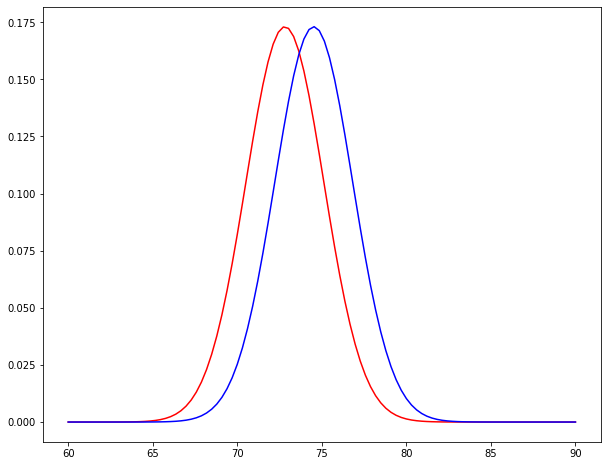

In [8]:
xx = np.linspace(60, 90, 100)
p0 = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-(xx-mu_0)**2/(2*sigma2))
p1 = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-(xx-mu_1)**2/(2*sigma2))

plt.figure(figsize=(10, 8))
plt.plot(xx, p0, 'r-')
plt.plot(xx, p1, 'b-');

This picture is not exactly what we want, it is the $P(X | y=k)$ for $y=0$ and $y=1$. We now need to use the values of this function to compute the Bayes probability: $P(y=k | X)$ at each point, note that this then takes into account the relative frequencies of each of the classes via the $P(y=k)$. 

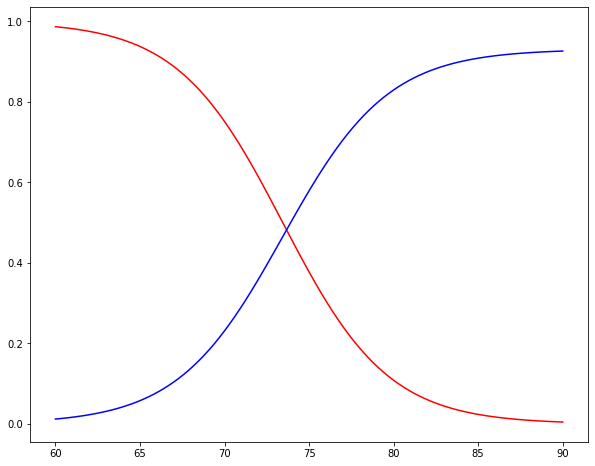

In [9]:
y1 = sum(y) / len(y)
y0 = 1 - y1
q0 = p0*y0 / (p0*y0 + p1*y1)
q1 = p1*y0 / (p0*y0 + p1*y1)

plt.figure(figsize=(10, 8))
plt.plot(xx, q0, 'r-')
plt.plot(xx, q1, 'b-');

The decision boundary is then at the location where these two probabilities cross. It is slightly to the right of where the distributions cross because of the correction due to the frequency of pitchers versus non-pitchers.

Note that the choice of decision boundary could be tuned if a particular problem (like one in medicine) required us to eliminate a particular type of error (false positives for example).

#### Using the Scikitlearn package

In [10]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [11]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

# Fixed for 1d

def plot_cat_model_1d(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    xx = np.arange(x_min, x_max, h)
    
    Z = clf.predict(np.c_[xx])

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.scatter(xx, Z, c=Z, cmap=cmap_light, marker='.');

    plt.scatter(X_train[:, 0], y_train, c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], y_test, c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Training Error: 0.656590084643289
Testing Error: 0.6359223300970874


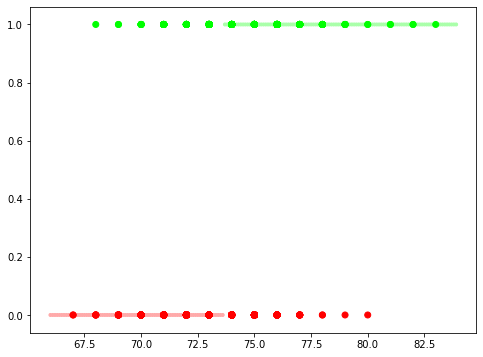

In [13]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train);
plot_cat_model_1d(clf, X_train, y_train, X_test, y_test)

### Quadratic Discriminant Analysis in One Dimension

Using quadratic discriminant analysis the decision boundary can be given by a quadratic function, which in one-dimension means we could have a decision boundary given by two points. This would accurately capture a problem where the data from one class was occupied an interval of the predictor feature surrounded by the data from the another class.

Here is an example of such a situation from the Kidney Disease dataset.

In [15]:
kd = pa.read_csv('Data Sets/Kidney/chronic_kidney_disease.csv', 
                 names=['age', 'bp', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                        'pus_cell_clumps', 'bacteria', 'blood_glucose', 'blood_urea', 'serum_creatinine', 
                        'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
                        'appetite', 'pedal_edema', 'anemia', 'class'])

kd.loc[kd.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'  # There is an extra tab character on some of the ckd values

kd.head()

,age,bp,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [16]:
# Note I have found a slightly better way to convert all of the values in a column to a new type

check = 'blood_urea'

kd = kd[kd.loc[:, check] != '?']
kd.loc[:, check] = kd.loc[:, check].astype('float')

In [17]:
X = np.array(kd[check])
y = np.array(kd.loc[:, 'class'].map({'ckd':1, 'notckd':0}))

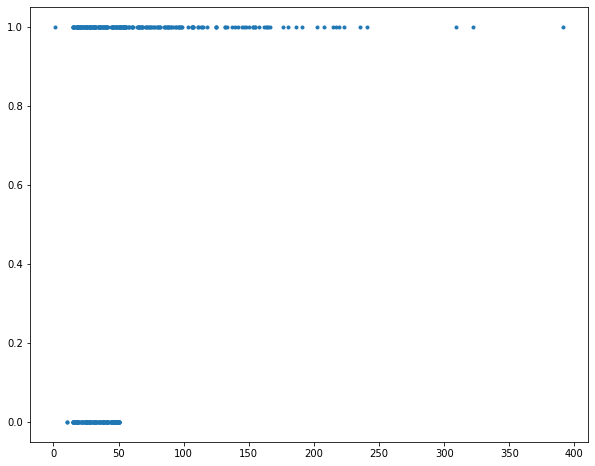

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(X, y, '.');

As with the LDA case we compute estimates of the means from each class.

In [21]:
mu_0 = X[y==0].mean()
mu_1 = X[y==1].mean()
mu_0, mu_1

(32.798611111111114, 72.38902953586498)

For the sake of comparison with LDA, the estimate of the variance for the whole population is computed, along with the conditional probability estimates. Culminating in showing you that from LDA we again get a single decision point.

In [24]:
mu = X.mean()
sigma2 = np.mean((X-mu)**2)
sigma2

2543.8592334029113

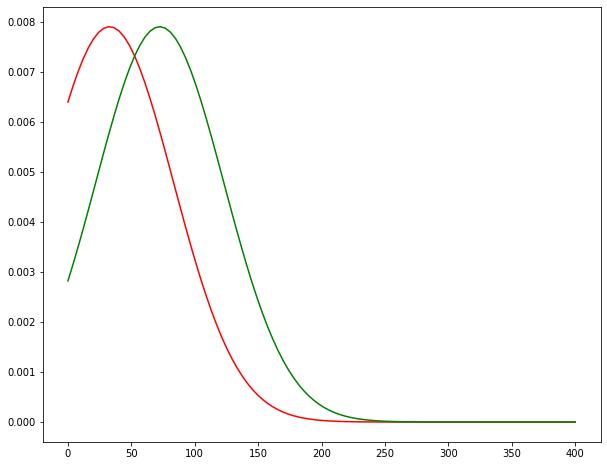

In [27]:
xx = np.linspace(0, 400, 100)

p0 = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-(xx-mu_0)**2/(2*sigma2))
p1 = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-(xx-mu_1)**2/(2*sigma2))

plt.figure(figsize=(10,8))
plt.plot(xx, p0, 'r-')
plt.plot(xx, p1, 'g-');

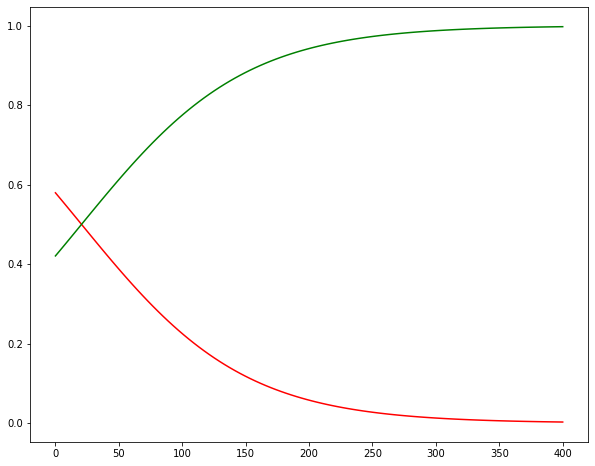

In [28]:
y1 = sum(y)/y.shape[0]
y0 = 1 - y1

q0 = p0*y0 / (p0*y0 + p1*y1)
q1 = p1*y1 / (p0*y0 + p1*y1)

plt.figure(figsize=(10,8))
plt.plot(xx, q0, 'r-')
plt.plot(xx, q1, 'g-');

For *Quadratic Discriminant Analysis* we drop the assumption that the variance can be estimated from the whole population and instead compute separate variances for each class. 

In [29]:
sigma2_0 = np.mean((X[y==0]-mu_0)**2)
sigma2_1 = np.mean((X[y==1]-mu_1)**2)
sigma2_0, sigma2_1

(130.20249807098767, 3417.981229859887)

The result are two variances of strikingly different sizes (which is clear from the original scatter plot. This leads to normal probablity distributions that are of different widths, and hence can cross each other more often.

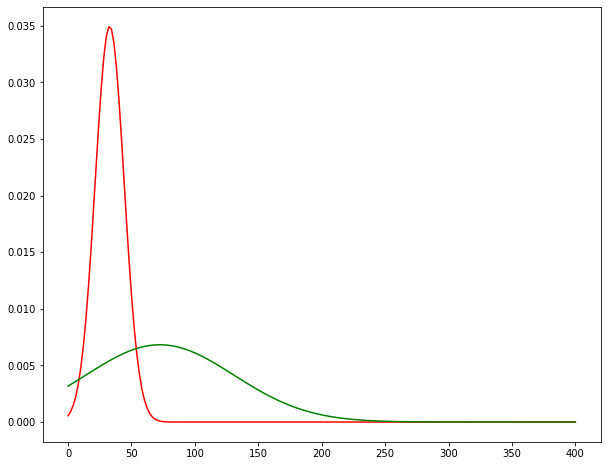

In [31]:
xx = np.linspace(0, 400, 200)

p0 = 1/np.sqrt(2*np.pi*sigma2_0)*np.exp(-(xx-mu_0)**2/(2*sigma2_0))
p1 = 1/np.sqrt(2*np.pi*sigma2_1)*np.exp(-(xx-mu_1)**2/(2*sigma2_1))

plt.figure(figsize=(10,8))
plt.plot(xx, p0, 'r-')
plt.plot(xx, p1, 'g-');

In turn, once inserted into Bayes' Theorem, this gives a decision boundary that consists of two points.

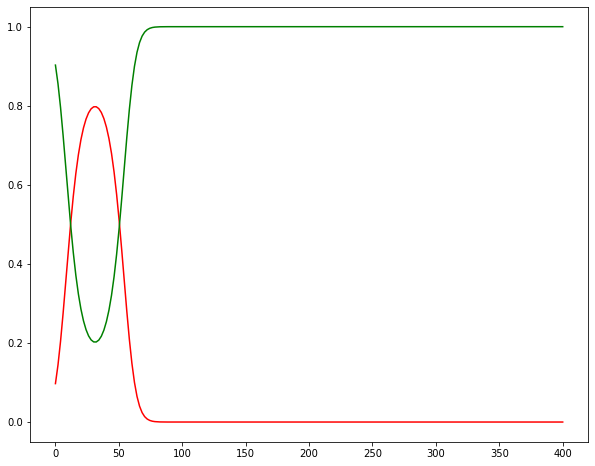

In [33]:
y1 = sum(y)/y.shape[0]
y0 = 1 - y1

q0 = p0*y0 / (p0*y0 + p1*y1)
q1 = p1*y1 / (p0*y0 + p1*y1)

plt.figure(figsize=(10,8))
plt.plot(xx, q0, 'r-')
plt.plot(xx, q1, 'g-');

The actual values can be computed.

In [48]:
s = abs(q1 - q0)
A, B = np.partition(s, 1)[:2]  
# numpy.partition is a convenient way to get the smallest values (or largest values) from an array
d1, d2 = np.where(s==A), np.where(s==B)
# nump.where(s==A) tells us for which index s gives A.
# we should automate the process of checking that they are far apart from each other, 
# however given the shape of the graph, I am confident they will be.

xx[d1], xx[d2]

(array([12.06030151]), array([50.25125628]))

So for *blood urea* values less than 12 or more than 50.3 we would be classifying the patient as having *chronic kidney disease*. 

### Higher Dimensional Versions


In higher dimensions we get linear boundaries, and with a generalization quadratic boundaries.

In [91]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

def plot_cat_model(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 2, X_train[:, 1].max() + 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

In [53]:
X = np.array(major_2[['Height', 'Weight']])
y = np.array(major_2['Position'])

In [54]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

Training Error: 0.6493349455864571
Testing Error: 0.6553398058252428


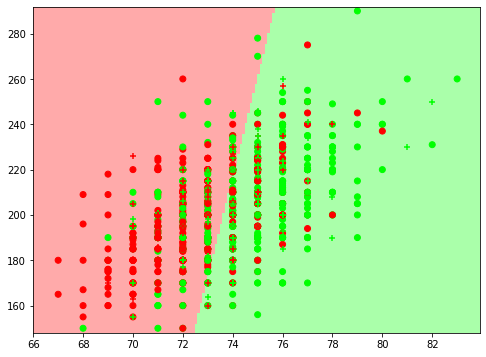

In [55]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train);
plot_cat_model(clf, X_train, y_train, X_test, y_test)

In [56]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Training Error: 0.656590084643289
Testing Error: 0.6844660194174758


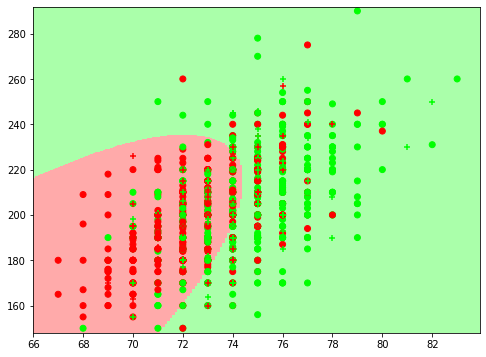

In [57]:
clf2 = QuadraticDiscriminantAnalysis()
clf2.fit(X_train, y_train)
plot_cat_model(clf2, X_train, y_train, X_test, y_test)

Comparing these methods to *Logistic Regression* and *k-Nearest Neighbors*

Training Error: 0.6505441354292624
Testing Error: 0.6553398058252428


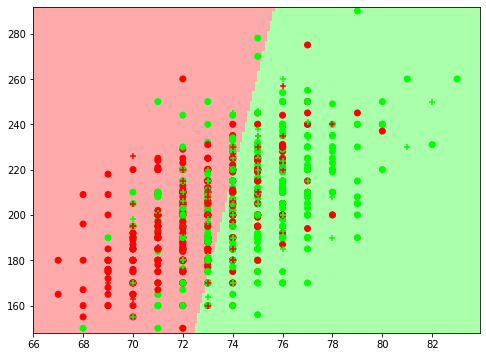

In [58]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver='lbfgs')
lg.fit(X_train, y_train)
plot_cat_model(lg, X_train, y_train, X_test, y_test)

Training Error: 0.6844014510278114
Testing Error: 0.6116504854368932


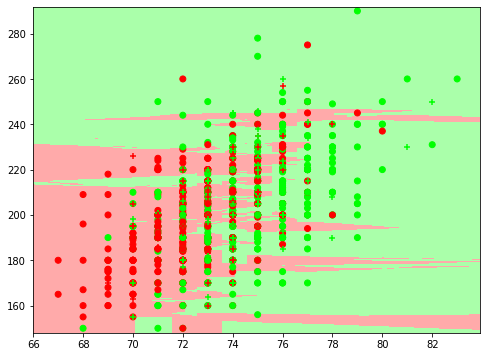

In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
plot_cat_model(knn, X_train, y_train, X_test, y_test)

## Support Vector Machines


### Maximal Margin Classifier

Support vector machines work from a different principle, but one which is motivated by the linear decsion boundaries we are getting in the previous results using *Logistic Regression* and *Linear Discriminant Analysis*. To motivate them we start with a classification problem that is relatively rare: one where there is a clear separation in the training data.

In [65]:
iris = pa.read_csv('Data Sets/iris.csv')
iris.head()

,sepal length,sepal width,petal length,petal width,flower type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


The flower type 0 is significantly separated from flower types 1 and 0:

In [66]:
X = np.array(iris[['petal length', 'petal width']])
y = np.array(iris['flower type'].map({0:0, 1:1, 2:1}) )

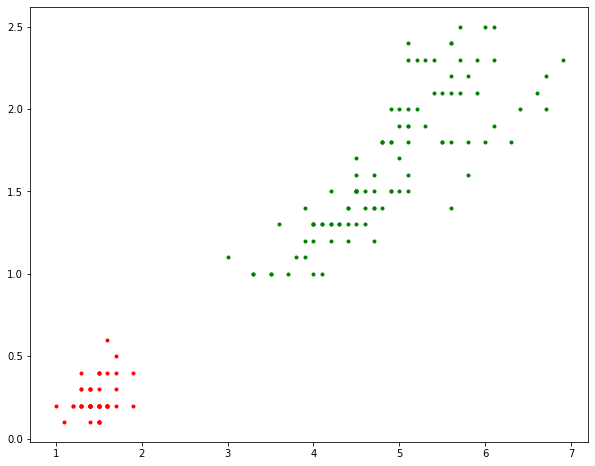

In [67]:
plt.figure(figsize=(10, 8))
plt.plot(X[y==0, 0], X[y==0, 1], 'r.')
plt.plot(X[y==1, 0], X[y==1, 1], 'g.');

In this case we see that there exists at least one (and hence infinitely many) lines that separate the two classes. 

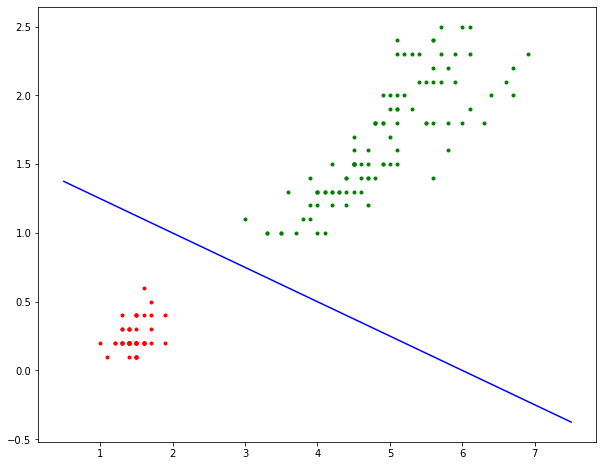

In [68]:
xx = np.linspace(0.5, 7.5, 50)
yy = 1.5 - 0.25*xx

plt.figure(figsize=(10, 8))
plt.plot(X[y==0, 0], X[y==0, 1], 'r.')
plt.plot(X[y==1, 0], X[y==1, 1], 'g.')
plt.plot(xx, yy, 'b-');

So the goal is to choose the best of all of the possible lines that separate the two classes. Of course, based on the whole class, you are not surprised and are expecting that there are many ideas one might mean by *best*.

One definition would be the dividing line that is as far as possible from both classes. We can define how far the line is from a class as the minimimum perpindicular distance from the points in that class.

The distance between the line and the closest training data is called the margin, and intuitively the larger the margin the better we expect the decision boundary to do on new data. Note then that the choice of decision boundary would only be affected by the points that are on the margin. I.e. if a point on the margin moves, it will cause the decision boundary to move; if a point not on the margin moves, so long as it does not move far enough to reach the margin, it will not cause the decision boundary to move. The points on the margine are called the *Support Vectors*.

This gives *Support Vector Machines*, derived from this idea, an interesting property. They are typically only dependent on a subset of the training data. Which means they are less likely to be affected by errors in some of the training data or changes in the training data, and are less dependent on training data far from the other classes. In the example above this means the Irises in the upper-right coordinate of the graph in particular will not have a strong affect on where we put the division line betweent type 0 and types 1 and 2 irises. 

The mathematical formulation of this motivating model, called the *Maximal Margin Classifier* is given by the optimization problem (with class values of $\{ -1, 1 \}$ rather than the 0 and 1 above:

$$ \mbox{maximize} \quad M \qquad \mbox{over choices of} \quad \beta_0, \beta_1, \dots \beta_p $$

$$ \mbox{subject to} \quad \sum_{j=0}^{p-1} \beta_j^2 = 1 $$

$$ \mbox{and} \quad y_i(\beta_0 + \beta_1 x_{i 1} + \beta_2 x_{i 2} + \dots + \beta_p x_{i, p} ) \geq M $$

for all $i$. 

### Support Vector Machines

Now however consider the original data set with three classes.

In [69]:
X = np.array(iris[['petal length', 'petal width']])
y = np.array(iris['flower type'] )

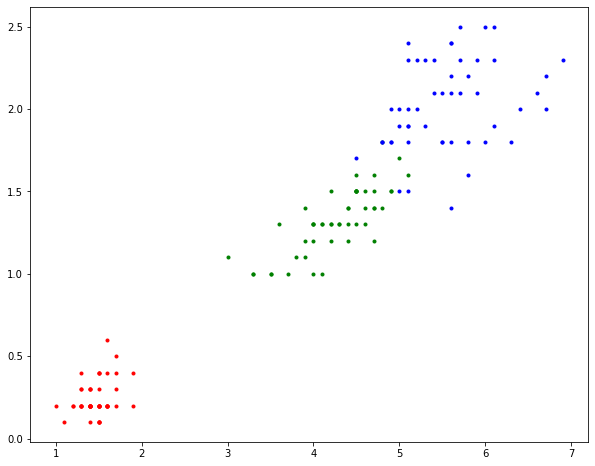

In [70]:
plt.figure(figsize=(10, 8))
plt.plot(X[y==0, 0], X[y==0, 1], 'r.')
plt.plot(X[y==1, 0], X[y==1, 1], 'g.')
plt.plot(X[y==2, 0], X[y==2, 1], 'b.');

In the case of the decision boundary between $y=1$ and $y=2$ it is not clear that there exists a linear boundary that will separate the two classes (when I teach this subject as an introductory mathematics course we would spend some time discussing how we might prove that there is in fact no line that separates these two classes, at least from the variables I am using).

What we can do is use a standard mathematical trick: **If there is no solution to the problem we want to solve or the solution is hard to find, relax the question.**

This is a mathematical trick made famous by the work of Strassen et al in number theory when they famously changed the question of: **Is n a prime number** a very hard problem into **Is n likely to be a prime a number** and successfully showed that this problem was tractable. [https://www-history.mcs.st-andrews.ac.uk/Biographies/Strassen.html](https://www-history.mcs.st-andrews.ac.uk/Biographies/Strassen.html)

In this context it means that what we should do is allow some of the data points from the training set to penetrate the margin or even to cross the decision boundary to the wrong side. That is we should allow some training error, which we have already seen in other models is an essential feature as we try to avoid overfitting.

The mathematical formulation above changes to:

$$ \mbox{maximize} \quad M \qquad \mbox{over choices of} \quad \beta_0, \beta_1, \dots \beta_p $$

$$ \mbox{subject to} \quad \sum_{j=0}^{p-1} \beta_j^2 = 1 ,$$

$$ \quad y_i(\beta_0 + \beta_1 x_{i 1} + \beta_2 x_{i 2} + \dots + \beta_p x_{i, p} ) \geq M (1- \epsilon_i) $$

for all $i$; and

$$ \epsilon_i > 0, \quad \sum_{i=0}^{n-1} \epsilon_i \leq C$$

where $C$ is a tuning parameter that identifies how much violation of the margin we will tolerate. How do we choose $C$?

### Applying Support Vector Machines

In [89]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

def plot_cat_model_3(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 2, X_train[:, 1].max() + 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))
    
# Updating the plotting function for three categories

In [86]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [87]:
from sklearn.svm import SVC

Training Error: 0.9583333333333334
Testing Error: 1.0


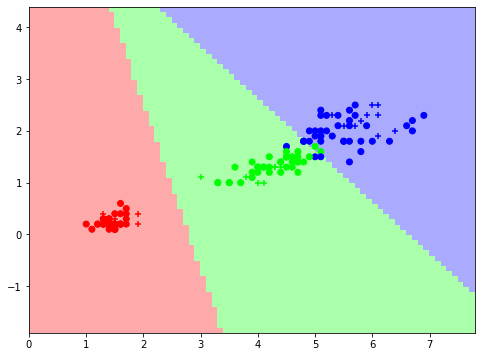

In [90]:
sv = SVC(C=1, gamma='scale', kernel='linear')
sv.fit(X_train, y_train)
plot_cat_model_3(sv, X_train, y_train, X_test, y_test)

The model does a very good job of working with the iris problem. Unless one of the problematic points ends up in the testing data we will typically have good performance on the testing set.

Returning to the baseball player problem, for which there is more overlap between the classes:

In [92]:
X = np.array(major_2[['Height', 'Weight']])
y = np.array(major_2['Position'])

In [93]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

Training Error: 0.6432889963724304
Testing Error: 0.6650485436893204


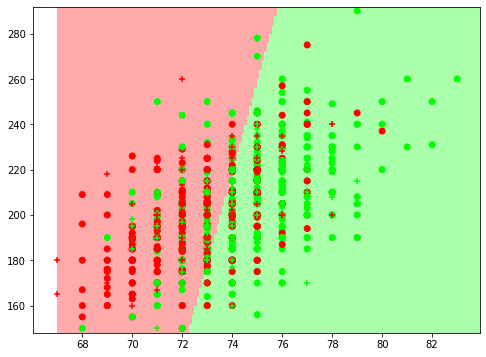

In [96]:
sv = SVC(C=2, gamma='scale', kernel='linear')
sv.fit(X_train, y_train)
plot_cat_model(sv, X_train, y_train, X_test, y_test)

Note the option being used in the model declaration of *kernel*.  This is an additional generalization of the full *Support Vector Machines* algorithm which allows us to specify what type of function to use to build the boundary. It can be *linear*, *poly*, *rbf* (for radial basis function, which is mostly what it sounds like), *sigmoid* (basically a logistic function), *precomputed* or even callable which would be a Python define class of functions to use for the boundary. 

How to choose the best kernel to use (other than the last two that can get complicated)?

Training Error: 0.6396614268440145
Testing Error: 0.6456310679611651


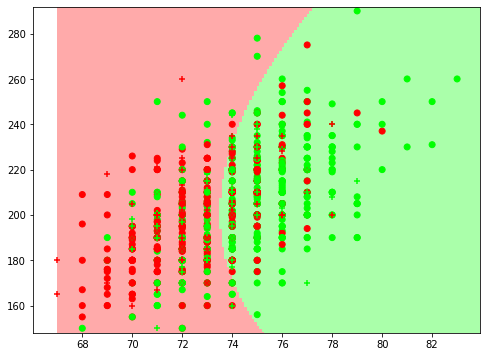

In [97]:
sv = SVC(C=2, gamma='scale', kernel='poly')
sv.fit(X_train, y_train)
plot_cat_model(sv, X_train, y_train, X_test, y_test)

Training Error: 0.6094316807738815
Testing Error: 0.6067961165048543


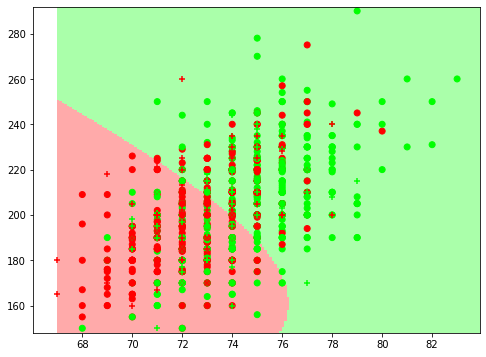

In [98]:
sv = SVC(C=2, gamma='scale', kernel='rbf')
sv.fit(X_train, y_train)
plot_cat_model(sv, X_train, y_train, X_test, y_test)

It is interesting that the curvature from these two kernels is opposite (and disagrees with that from the *Quadratic Discriminant Analysis*) the performance of all three is not too far apart.

### Speed

You might have noticed, if you have been following along in Python, that these algorithms seem to take longer. The training time for the *SVC* algorithm is definitely one of its disadvantages and for a large dataset will become problematic if you need results fast or are still exploring your problem. See the scikitlearn page for some advice on how to proceed and in particular on the *LinearSVC* model that will offer some speed improvements over the *SVC* model. 

Starting with this class of model, the speed of training a model will become more of a consideration as we go on.